<a href="https://colab.research.google.com/github/TH3SOLO1ST/ornithopter_cfd/blob/main/ornithopter_cfd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install numpy scipy matplotlib jax jaxlib ffmpeg-python
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Data saved to ornithopter_data.npz
Lift stats: min=-28.555, max=2152.820, mean=515.583
Thrust stats: min=-151.987, max=1868.638, mean=1727.123
Velocity field stats (unclipped): min=2.199, max=97.969, mean=71.437


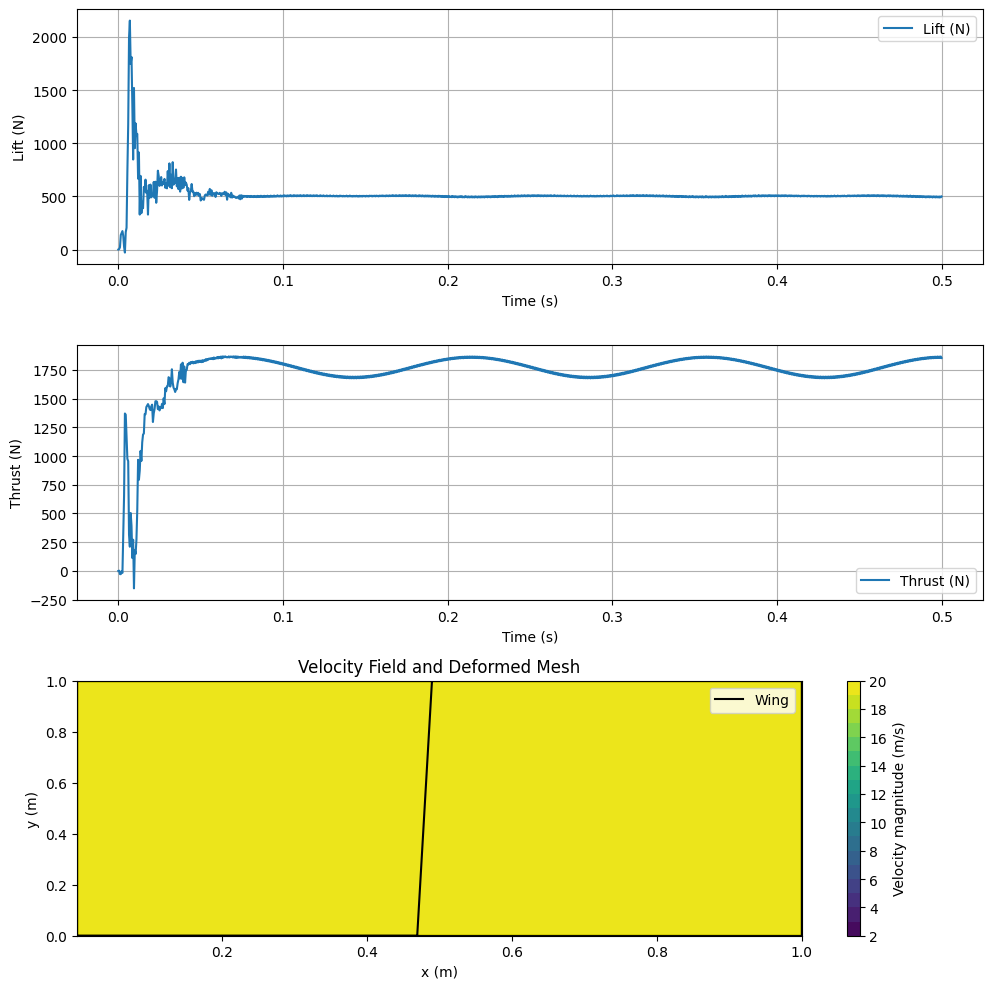

Plots saved to ornithopter_results.png


In [17]:
#!/usr/bin/env python3
"""
ornithopter_cfd.py: 2D incompressible Navier-Stokes solver for an ornithopter wing.
Simulates flapping and pitching motion using a dynamic mesh with RBF interpolation.
Computes lift and thrust, visualizes results, and saves output (plots, data).

Dependencies:
- numpy>=1.20
- scipy>=1.7
- matplotlib>=3.4
- jax>=0.4
- jaxlib>=0.4

Configuration:
- Parameters are read from config.json

Output:
- ornithopter_results.png: Plots of lift, thrust, and velocity field
- ornithopter_data.npz: Simulation data (lift, thrust, u, v, X, Y)

Usage in Google Colab:
1. Upload config.json to Colab.
2. Install dependencies: !pip install numpy scipy matplotlib jax jaxlib
3. Run the script.
4. Download outputs using google.colab.files or save to Google Drive.

Author: M Talha Yasin
Date: May 29, 2025
"""

import json
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import RBFInterpolator
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import jit

# Ensure matplotlib works in Colab
%matplotlib inline

def load_config():
    """Load simulation parameters from config.json."""
    try:
        with open("config.json", "r") as f:
            config = json.load(f)
        return config
    except FileNotFoundError:
        raise FileNotFoundError("config.json not found. Upload it to Colab's working directory.")
    except json.JSONDecodeError:
        raise ValueError("Invalid JSON format in config.json.")

def wing_kinematics(t, f, h, alpha_max):
    """Compute wing kinematics: flapping and pitching."""
    h_t = h * np.sin(2 * np.pi * f * t)
    h_dot = 2 * np.pi * f * h * np.cos(2 * np.pi * f * t)
    alpha_t = alpha_max * np.sin(2 * np.pi * f * t + np.pi/2)
    alpha_dot = 2 * np.pi * f * alpha_max * np.cos(2 * np.pi * f * t + np.pi/2)
    return h_t, h_dot, alpha_t, alpha_dot

def update_mesh_rbf(t, X, Y, c, f, h, alpha_max):
    """Update mesh using RBF interpolation with bounded coordinates."""
    h_t, _, alpha_t, _ = wing_kinematics(t, f, h, alpha_max)
    wing_x = np.linspace(c/4, 3*c/4, 20)
    wing_y = c/2 * np.ones_like(wing_x)
    mid_chord = c/2
    wing_y_new = wing_y + h_t
    wing_x_new = wing_x + (wing_x - mid_chord) * (np.cos(alpha_t) - 1) - (wing_y - c/2) * np.sin(alpha_t)
    wing_y_new = wing_y_new + (wing_x - mid_chord) * np.sin(alpha_t) + (wing_y - c/2) * (np.cos(alpha_t) - 1)

    # Constrain wing coordinates to domain
    wing_x_new = np.clip(wing_x_new, 0, c)
    wing_y_new = np.clip(wing_y_new, 0, c)

    boundary_pts = np.vstack([np.concatenate([wing_x, [0, c, 0, c]]),
                              np.concatenate([wing_y, [0, 0, c, c]])]).T
    boundary_pts_new = np.vstack([np.concatenate([wing_x_new, [0, c, 0, c]]),
                                  np.concatenate([wing_y_new, [0, 0, c, c]])]).T

    rbf = RBFInterpolator(boundary_pts, boundary_pts_new, kernel='gaussian', epsilon=1.0)  # Reduced epsilon
    grid_pts = np.vstack([X.ravel(), Y.ravel()]).T
    new_pts = rbf(grid_pts)
    X_new = new_pts[:, 0].reshape(X.shape)
    Y_new = new_pts[:, 1].reshape(Y.shape)

    # Validate and constrain mesh
    if np.any(np.isnan(X_new)) or np.any(np.isnan(Y_new)) or \
       np.any(np.isinf(X_new)) or np.any(np.isinf(Y_new)):
        raise ValueError(f"Invalid mesh at t={t:.3f}")
    X_new = np.clip(X_new, 0, c)
    Y_new = np.clip(Y_new, 0, c)
    if np.any(X_new < 0) or np.any(X_new > c) or np.any(Y_new < 0) or np.any(Y_new > c):
        print(f"Warning: Mesh coordinates out of bounds at t={t:.3f} (after clipping)")
    mesh_disp = np.max(np.sqrt((X_new - X)**2 + (Y_new - Y)**2))
    if mesh_disp > c/2:
        print(f"Warning: Large mesh displacement {mesh_disp:.3f} at t={t:.3f}")

    return X_new, Y_new

def build_laplacian(nx, ny, dx, dy):
    """Build sparse Laplacian matrix for pressure Poisson equation."""
    N = nx * ny
    main_diag = -2/dx**2 - 2/dy**2 * np.ones(N)
    off_diag_x = 1/dx**2 * np.ones(N-1)
    off_diag_y = 1/dy**2 * np.ones(N-nx)
    off_diag_x[np.arange(N-1) % nx == nx-1] = 0
    A = diags([off_diag_y, off_diag_x, main_diag, off_diag_x, off_diag_y],
              [-nx, -1, 0, 1, nx], shape=(N, N)).tocsr()
    return A

@jit
def compute_advection(u, v, dx, dy, dt, mesh_velocity_x, mesh_velocity_y):
    """Compute advection term using JAX with upwind differencing."""
    u_rel = u - mesh_velocity_x
    v_rel = v - mesh_velocity_y
    u_diff_x = jnp.where(u_rel[1:-1, 1:-1] >= 0,
                         (u[1:-1, 1:-1] - u[:-2, 1:-1]) / dx,
                         (u[2:, 1:-1] - u[1:-1, 1:-1]) / dx)
    u_diff_y = jnp.where(v_rel[1:-1, 1:-1] >= 0,
                         (u[1:-1, 1:-1] - u[1:-1, :-2]) / dy,
                         (u[1:-1, 2:] - u[1:-1, 1:-1]) / dy)
    v_diff_x = jnp.where(u_rel[1:-1, 1:-1] >= 0,
                         (v[1:-1, 1:-1] - v[:-2, 1:-1]) / dx,
                         (v[2:, 1:-1] - v[1:-1, 1:-1]) / dx)
    v_diff_y = jnp.where(v_rel[1:-1, 1:-1] >= 0,
                         (v[1:-1, 1:-1] - v[1:-1, :-2]) / dy,
                         (v[1:-1, 2:] - v[1:-1, 1:-1]) / dy)
    u_diff_x = jnp.pad(u_diff_x, ((1, 1), (1, 1)), mode='edge')
    u_diff_y = jnp.pad(u_diff_y, ((1, 1), (1, 1)), mode='edge')
    v_diff_x = jnp.pad(v_diff_x, ((1, 1), (1, 1)), mode='edge')
    v_diff_y = jnp.pad(v_diff_y, ((1, 1), (1, 1)), mode='edge')
    u_adv = u - dt * (u_rel * u_diff_x + v_rel * u_diff_y)
    v_adv = v - dt * (u_rel * v_diff_x + v_rel * v_diff_y)
    u_adv = jnp.clip(u_adv, -50, 50)
    v_adv = jnp.clip(v_adv, -50, 50)
    return u_adv, v_adv

def solve_navier_stokes(u, v, p, X, Y, nx, ny, dx, dy, dt, nu, t, c, U_inf, f, h, alpha_max):
    """Solve 2D incompressible Navier-Stokes using Chorin projection."""
    u_jax = jnp.array(u)
    v_jax = jnp.array(v)
    X_new, Y_new = update_mesh_rbf(t, X, Y, c, f, h, alpha_max)
    mesh_velocity_x = jnp.array((X_new - X) / dt)
    mesh_velocity_y = jnp.array((Y_new - Y) / dt)

    h_t, h_dot, alpha_t, alpha_dot = wing_kinematics(t, f, h, alpha_max)

    # Step 1: Intermediate velocity
    u_star = u.copy()
    v_star = v.copy()
    u_adv, v_adv = compute_advection(u_jax, v_jax, dx, dy, dt, mesh_velocity_x, mesh_velocity_y)
    u_adv, v_adv = np.array(u_adv), np.array(v_adv)

    if np.any(np.isnan(u_adv)) or np.any(np.isnan(v_adv)):
        print(f"Warning: NaN in advection at t={t:.3f}")

    for i in range(1, nx-1):
        for j in range(1, ny-1):
            u_star[i, j] = u_adv[i, j] + dt * nu * (
                (u[i+1, j] - 2*u[i, j] + u[i-1, j]) / dx**2 +
                (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / dy**2
            )
            v_star[i, j] = v_adv[i, j] + dt * nu * (
                (v[i+1, j] - 2*v[i, j] + v[i-1, j]) / dx**2 +
                (v[i, j+1] - 2*v[i, j] + v[i, j-1]) / dy**2
            )

    if np.any(np.isnan(u_star)) or np.any(np.isnan(v_star)):
        print(f"Warning: NaN in u_star/v_star at t={t:.3f}")
        u_star = np.clip(u_star, -50, 50)
        v_star = np.clip(v_star, -50, 50)

    # Step 2: Pressure Poisson equation
    div = np.zeros((nx, ny))
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            div[i, j] = (u_star[i+1, j] - u_star[i-1, j]) / (2*dx) + \
                        (v_star[i, j+1] - v_star[i, j-1]) / (2*dy)
    div_flat = div.ravel() / dt
    A = build_laplacian(nx, ny, dx, dy)
    p_flat = spsolve(A, -div_flat)
    p_new = p_flat.reshape((nx, ny))
    p_new = np.clip(p_new, -1e4, 1e4)

    # Step 3: Correct velocity
    u_new = u_star.copy()
    v_new = v_star.copy()
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            u_new[i, j] = u_star[i, j] - dt * (p_new[i+1, j] - p_new[i-1, j]) / (2*dx)
            v_new[i, j] = v_star[i, j] - dt * (p_new[i, j+1] - p_new[i, j-1]) / (2*dy)

    if np.any(np.isnan(u_new)) or np.any(np.isnan(v_new)):
        print(f"Warning: NaN in u_new/v_new at t={t:.3f}")
        u_new = np.clip(u_new, -50, 50)
        v_new = np.clip(v_new, -50, 50)

    # Boundary conditions
    wing_idx = int(ny/2)
    wing_velocity_x = -h_dot * np.sin(alpha_t)
    wing_velocity_y = h_dot * np.cos(alpha_t)
    wing_mask = (x >= c/4) & (x <= 3*c/4)
    u_new[wing_mask, wing_idx] = wing_velocity_x
    v_new[wing_mask, wing_idx] = wing_velocity_y
    u_new[0, :] = U_inf
    u_new[-1, :] = U_inf
    v_new[0, :] = 0
    v_new[-1, :] = 0

    return u_new, v_new, p_new, X_new, Y_new, alpha_t

def generate_3d_mesh(c, output_file="wing3d.msh"):
    """Placeholder for 3D mesh generation using Gmsh."""
    try:
        import gmsh
        gmsh.initialize()
        gmsh.model.add("wing3d")
        gmsh.model.geo.addPoint(0, 0, 0, 0.1, 1)
        gmsh.model.geo.addPoint(c, 0, 0, 0.1, 2)
        gmsh.model.geo.addPoint(c, c, 0, 0.1, 3)
        gmsh.model.geo.addPoint(0, c, 0, 0.1, 4)
        gmsh.model.geo.addLine(1, 2, 1)
        gmsh.model.geo.addLine(2, 3, 2)
        gmsh.model.geo.addLine(3, 4, 3)
        gmsh.model.geo.addLine(4, 1, 4)
        gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
        gmsh.model.geo.addPlaneSurface([1], 1)
        gmsh.model.geo.extrude([(2, 1)], 0, 0, 0.1)
        gmsh.model.geo.synchronize()
        gmsh.model.mesh.generate(3)
        gmsh.write(output_file)
        gmsh.finalize()
        print(f"3D mesh saved to {output_file}.")
    except ImportError:
        print("Gmsh not installed. Install with `pip install gmsh`.")

def main():
    """Run the ornithopter CFD simulation."""
    try:
        # Load configuration
        config = load_config()
        nx = config["nx"]
        ny = config["ny"]
        t_max = config["t_max"]
        c = config["c"]
        f = config["f"]
        h = config["h"]
        alpha_max = np.radians(config["alpha_max_deg"])
        U_inf = config["U_inf"]
        rho = config["rho"]
        nu = config["nu"]
        dt = config["dt"]

        # Grid setup
        global x
        dx = c / (nx - 1)
        dy = c / (ny - 1)
        x = np.linspace(0, c, nx)
        y = np.linspace(0, c, ny)
        X, Y = np.meshgrid(x, y)
        N = int(t_max / dt)

        # CFL condition check
        u_max = U_inf + 2 * np.pi * f * h
        cfl_adv = min(dx, dy) / u_max
        cfl_diff = min(dx**2, dy**2) / (2 * nu)
        cfl_max = min(cfl_adv, cfl_diff)
        if dt > 0.5 * cfl_max:
            raise ValueError(f"Time step too large (dt={dt:.6f}). Must be < {0.5*cfl_max:.6f}.")

        # Initialize fields
        u = U_inf * np.ones((nx, ny))
        v = np.zeros((nx, ny))
        p = np.zeros((nx, ny))
        lift = np.zeros(N)
        thrust = np.zeros(N)

        # Simulation loop
        for i in range(N):
            t_i = i * dt
            u, v, p, X, Y, alpha_t = solve_navier_stokes(u, v, p, X, Y, nx, ny, dx, dy, dt, nu, t_i, c, U_inf, f, h, alpha_max)

            # Compute forces
            wing_idx = int(ny/2)
            pressure_sum = np.sum(p[:, wing_idx])
            lift[i] = -pressure_sum * dx * np.cos(alpha_t)
            thrust[i] = pressure_sum * dx * np.sin(alpha_t) + \
                        rho * np.sum(u[:, wing_idx] * v[:, wing_idx]) * dx
            if np.isnan(lift[i]) or np.isinf(lift[i]):
                print(f"Invalid lift at t={t_i:.3f}: pressure_sum={pressure_sum}, alpha_t={alpha_t}")

        # Save data
        np.savez("ornithopter_data.npz", lift=lift, thrust=thrust, X=X, Y=Y, u=u, v=v)
        print("Data saved to ornithopter_data.npz")

        # Plot results
        plt.figure(figsize=(10, 10))
        plt.subplot(3, 1, 1)
        print(f"Lift stats: min={np.min(lift):.3f}, max={np.max(lift):.3f}, mean={np.mean(lift):.3f}")
        if np.all(np.isnan(lift)) or np.all(lift == 0):
            print("Warning: Lift data is invalid or zero.")
        else:
            plt.plot(np.linspace(0, t_max, N), lift, label='Lift (N)')
        plt.xlabel('Time (s)')
        plt.ylabel('Lift (N)')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        print(f"Thrust stats: min={np.min(thrust):.3f}, max={np.max(thrust):.3f}, mean={np.mean(thrust):.3f}")
        if np.all(np.isnan(thrust)) or np.all(thrust == 0):
            print("Warning: Thrust data is invalid or zero.")
        else:
            plt.plot(np.linspace(0, t_max, N), thrust, label='Thrust (N)')
        plt.xlabel('Time (s)')
        plt.ylabel('Thrust (N)')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 3)
        vel_mag = np.sqrt(u**2 + v**2)
        print(f"Velocity field stats (unclipped): min={np.min(vel_mag):.3f}, max={np.max(vel_mag):.3f}, mean={np.mean(vel_mag):.3f}")
        vel_mag_clipped = np.clip(vel_mag, 0, 20)
        if np.all(np.isnan(vel_mag)) or np.all(vel_mag == 0):
            print("Warning: Velocity field is invalid or zero.")
        else:
            plt.contourf(X, Y, vel_mag_clipped, levels=20)
            plt.colorbar(label='Velocity magnitude (m/s)')
            plt.plot(x, Y[:, int(ny/2)], 'k-', label='Wing')
            plt.plot(X, Y, 'k-', alpha=0.1)
            plt.plot(X.T, Y.T, 'k-', alpha=0.1)
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        plt.title('Velocity Field and Deformed Mesh')
        plt.legend()

        plt.tight_layout()
        plt.savefig("ornithopter_results.png")
        plt.show()
        print("Plots saved to ornithopter_results.png")

    except ImportError as e:
        print(f"Error: Missing required library: {e}")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")

if __name__ == "__main__":
    main()

In [18]:
from numpy import load

data = load('ornithopter_data.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

lift
[  -0.            4.30501146   21.85670577  136.4748812   154.05450381
  173.48587695  128.19793178   25.25307901  -28.55458139  164.19508106
  205.04070002  736.07361855 1176.24153106 1992.18280172 2152.82039596
 1744.8449774  1810.90090229 1372.91663839  846.46172609 1519.30488712
  952.89214051 1185.81076731 1073.75506846 1087.69587347  666.14116393
  912.83514501  328.82721485  692.59233445  342.12410067  448.57610835
  388.41778962  589.03577199  548.14875467  657.3798141   531.77673046
  552.41908167  328.65810617  604.67695251  487.46074588  610.64374078
  490.86429738  504.45338232  512.72323795  635.38453985  486.24732601
  637.56581001  439.65428264  551.13904153  741.39044025  692.38093631
  598.4530209   619.9312938   681.49624959  602.48172478  634.32825657
  618.71348665  664.07003543  580.80451822  622.33435974  575.51649369
  737.45885998  600.03553011  810.01947222  585.27639996  703.29715015
  576.48459962  821.43257686  609.8702221   664.24079715  624.51386206
 